# Extracting and Converting OpenStreetMap data in Python
OpenStreetMap is an open source collaborative mapping project that has tons of really valuable and freely available data. However, in order to use it in most applications it needs to be converted to another format. If working with large amounts of data, the best approach is to use a tool such as ```imposm``` or ```osm2pgsql```, both of which first import the data into a PostgreSQL/PostGIS database. From there the data can be queried or exported. However, if working with smaller amounts of data where a spatial database is not necessary, there is a quick and easy way to extract data from an OSM file (XML based) using a driver in the Python OGR library. I demonstrate this approach below using a sample of data in my neighborhood in San Francisco. 

The OSM file that I use in this example can be downloaded from the following link on the OpenStreetMap website (http://www.openstreetmap.org/export#map=17/37.78292/-122.46336). The area I downloaded represents the Inner Richmond neighborhood, roughly between 6th and 3rd Avenues, along Geary and Clement.

Below, I go through an example where I read in the points layer from the OSM data using the OGR driver, extract relevant attributes and location, convert the data to a GeoPandas GeoDataFrame, and then plot it on a map.

First I import the necessary modules - ``ogr`` is used to read in the OSM data, ```shapely``` is used to convert the geometries, ```geopandas``` is used to store the data and geometry, and ```matplotlib``` is used to plot it. 

In [ ]:
osm = """
<iframe width="500" height="400" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" \
src="http://www.openstreetmap.org/export/embed.html?bbox=\
-122.47178%2C37.77859%2C-122.45493%2C37.78724&amp;layer=mapnik" \
style="border: 1px solid black"></iframe><br/><small><a \
href="http://www.openstreetmap.org/#map=17/37.78292/-122.46336">View Larger Map</a></small>
"""
display.HTML(osm)

In [6]:
%matplotlib inline
import ogr
import shapely
from shapely.geometry import *
import geopandas as gpd
import matplotlib.pyplot as plt

I then define the relevant OGR driver, which in this case is called "OSM". I use that driver to open my OSM file, which categorizes the features into 5 layers:

1. **points** : "node" features
2. **lines** : "way" features that are recognized as non-area.
3. **multilinestrings** : "relation" features that form a multilinestring
4. **multipolygons** : "relation" features that form a multipolygon and "way" features that are recognized as area.
5. **other_relations** : "relation" features that do not belong to the above 2 layers.

I use the ```GetLayer``` method to extract the "points" layer and iterate over the features in this layer, storing them in a list. As shown below, there are 39 features in this point layer.

In [17]:
driver=ogr.GetDriverByName('OSM')
data = driver.Open('inner_richmond.osm')
layer = data.GetLayer('points')

features=[x for x in layer]
print len(features)

39


Next I loop through each of these point features and extract some attributes, including the location. I convert the feature attributes to JSON and extract the feature name; the feature 'Highway' properties (relevant for bus stops, traffic signals, etc); the "Amenity" description (if relevant); and the lat/long coordinates. I use the coordinates to create ```shapely``` geometry objects and build a GeoDataFrame with the extracted data. Depending on the attributes of interest, you may need to tweak this code to obtain other information within the "other_tags" category.

In [7]:
data_list=[]
for feature in features:
    data=feature.ExportToJson(as_object=True)
    coords=data['geometry']['coordinates']
    shapely_geo=Point(coords[0],coords[1])
    name=data['properties']['name']
    highway=data['properties']['highway']
    other_tags=data['properties']['other_tags']
    if other_tags and 'amenity' in other_tags:
        feat=[x for x in other_tags.split(',') if 'amenity' in x][0]
        amenity=feat[feat.rfind('>')+2:feat.rfind('"')]
    else:
        amenity=None
    data_list.append([name,highway,amenity,shapely_geo])
gdf=gpd.GeoDataFrame(data_list,columns=['Name','Highway','Amenity','geometry'],crs={'init': 'epsg:4326'}).to_crs(epsg=3310)

In [12]:
gdf.tail()

,Name,Highway,Amenity,geometry
34,8th Avenue,bus_stop,None,POINT (-216757.5129094814 -22895.74381802278)
35,Best and Fresh Food,None,None,POINT (-216785.1594229685 -23117.45584711386)
36,None,None,None,POINT (-216742.9049959361 -23116.90880399616)
37,May Shun Trading,None,None,POINT (-216809.4551698703 -23116.59043585416)
38,Grain D'or,None,restaurant,POINT (-216493.3926737724 -23108.28007747373)


I can then easily manipulate or query the data any way I normally would using Pandas/GeoPandas. Below, I extract the features that represent coffee shops or bars and plot them on a map using ```matplotlib```. If the data is needed in another format (shapefile, geojson, etc) it can easily be exported using the ```GeoDataFrame.to_file()``` method.

In [14]:
cafe_bar=gdf[gdf.Amenity.isin(['cafe','pub','bar'])]
cafe_bar

,Name,Highway,Amenity,geometry
18,Cafe Coco,None,cafe,POINT (-216737.0424637551 -23366.19233996468)
21,Blue Danube Coffee House,None,cafe,POINT (-216562.6742979415 -23112.86356830364)
25,Rockit Room,None,bar,POINT (-216668.2580983618 -23113.41150188772)
26,The Bitter End,None,pub,POINT (-216689.4750393766 -23143.02973108692)
28,Ireland's 32,None,pub,POINT (-216469.8690838547 -23316.07564048655)


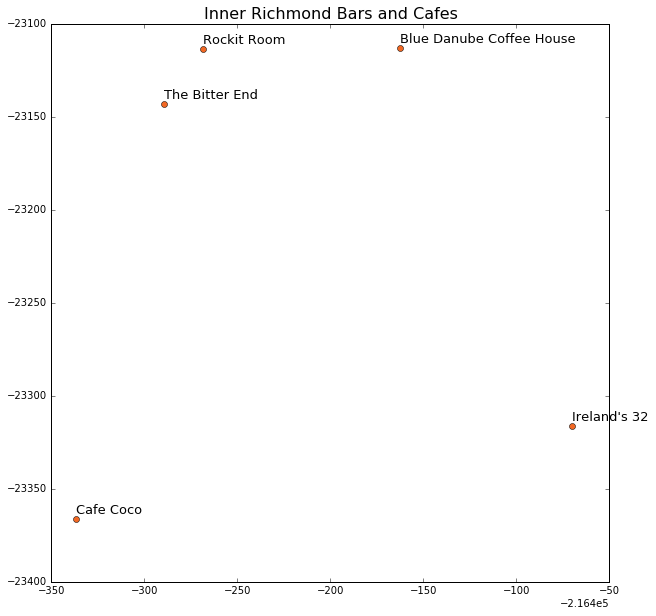

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
for i,row in cafe_bar.iterrows():
    x=row['geometry'].x
    y=row['geometry'].y
    plt.annotate(row['Name'], xy=(x,y), size=13, xytext=(0,5), textcoords='offset points')
    plt.plot(x,y,'o', color='#f16824')
    ax.set(aspect=1)
title=plt.title('Inner Richmond Bars and Cafes',size=16)

And there you have it! Again, with large datasets it would be more appropriate to use a tool that directly imports the OSM data into a spatial database. However, this is a really quick and easy way to extract smaller amounts of data if needed!